Marco Ferrè - 953544 - marco1.ferre@mail.polimi.it

---

# Project #6: GPU-based implementation of Template attacks
POLIMI - Embedded Systems 2021/2022

# Template Attacks

*https://wiki.newae.com/Template_Attacks*


---

Template attacks are a powerful type of side-channel attack. These attacks are a subset of profiling attacks, where an attacker creates a "profile" of a sensitive device and applies this profile to quickly find a victim's secret key.

Template attacks require more setup than CPA attacks. To perform a template attack, the attacker must have access to another copy of the protected device that they can fully control. Then, they must perform a great deal of pre-processing to create the template - in practice, this may take dozens of thousands of power traces. However, the advantages are that template attacks require a very small number of traces from the victim to complete the attack. With enough pre-processing, the key may be able to be recovered from just a single trace.

There are four steps to a template attack:

1. Using a copy of the protected device, record a large number of power traces using many different inputs (plaintexts and keys). Ensure that enough traces are recorded to give us information about each subkey value.
2. Create a template of the device's operation. This template notes a few "points of interest" in the power traces and a multivariate distribution of the power traces at each point.
3. On the victim device, record a small number of power traces. Use multiple plaintexts. (We have no control over the secret key, which is fixed.)
4. Apply the template to the attack traces. For each subkey, track which value is most likely to be the correct subkey. Continue until the key has been recovered.



In [45]:
import cupy as cp
import numpy as np
import matplotlib.pyplot as plt
from traces_bin_reader.TracesBin import TracesBin

{'name': b'NVIDIA GeForce RTX 3070',
 'totalGlobalMem': 8589410304,
 'sharedMemPerBlock': 49152,
 'regsPerBlock': 65536,
 'warpSize': 32,
 'maxThreadsPerBlock': 1024,
 'maxThreadsDim': (1024, 1024, 64),
 'maxGridSize': (2147483647, 65535, 65535),
 'clockRate': 1755000,
 'totalConstMem': 65536,
 'major': 8,
 'minor': 6,
 'textureAlignment': 512,
 'texturePitchAlignment': 32,
 'multiProcessorCount': 46,
 'kernelExecTimeoutEnabled': 1,
 'integrated': 0,
 'canMapHostMemory': 1,
 'computeMode': 0,
 'maxTexture1D': 131072,
 'maxTexture2D': (131072, 65536),
 'maxTexture3D': (16384, 16384, 16384),
 'concurrentKernels': 1,
 'ECCEnabled': 0,
 'pciBusID': 1,
 'pciDeviceID': 0,
 'pciDomainID': 0,
 'tccDriver': 0,
 'memoryClockRate': 7001000,
 'memoryBusWidth': 256,
 'l2CacheSize': 4194304,
 'maxThreadsPerMultiProcessor': 1536,
 'isMultiGpuBoard': 0,
 'cooperativeLaunch': 1,
 'cooperativeMultiDeviceLaunch': 0,
 'deviceOverlap': 1,
 'maxTexture1DMipmap': 32768,
 'maxTexture1DLinear': 268435456,
 'ma

# Loading Data
From the _fpga100t_duDFS_V_1.00_F_50.000MHz_ containing 258 operations, 500 traces with 134016 samples each, using BynaryReader tools, we load the data into a _np Array_ ready to be converted in a _cp Array_

In [46]:
import glob
data_dir = "fpga100t_duDFS_V_1.00_F_50.000MHz/"

# All files and directories ending with .dat and that don't begin with a dot:
op_files = glob.glob(data_dir + "*.dat")

train_set = range(100, 500)
attack_set = range(99)

In [47]:
f = TracesBin(op_files[4])
[trainTraces, trainTexts] = f.getTraces(train_set)
#[trainTraces, trainTexts] = f.getAllTraces()
[atkTraces, atkTexts] = f.getTraces(attack_set)
key = f.getKey()

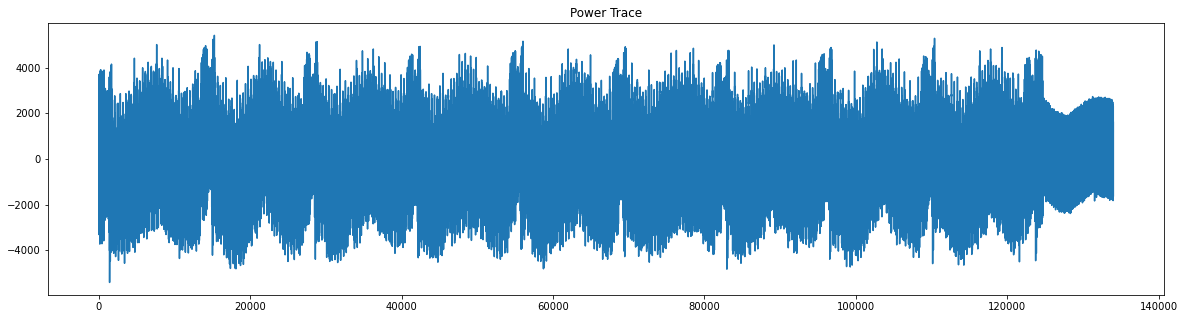

In [48]:
plt.figure(figsize=(20,5))
plt.title('Power Trace')
plt.plot(trainTraces[0])
plt.show()

# Creating the Template

A template is a set of probability distributions that describe what the power traces look like for many different keys. Effectively, a template says: "If you're going to use key $k$, your power trace will look like the distribution $f_k(\mathbf{x})$". We can use this information to find subtle differences between power traces and to make very good key guesses for a single power trace.


## Number of Traces
One of the downsides of template attacks is that they require a great number of traces to be preprocessed before the attack can begin. This is mainly for statistical reasons. In order to come up with a good distribution to model the power traces for *every key*, we need a large number of traces for *every key*. For example, if we're going to attack a single subkey of AES-128, then we need to create 256 power consumption models (one for every number from 0 to 255). In order to get enough data to make good models, we need tens of thousands of traces.

Note that we don't have to model every single key. One good alternative is to model a sensitive part of the algorithm, like the substitution box in AES. We can get away with a much smaller number of traces here; if we make a model for every possible Hamming weight, then we would end up with 9 models, which is an order of magnitude smaller. However, then we can't recover the key from a single attack trace - we need more information to recover the secret key.


In [49]:
sbox = np.array([
    0x63,0x7c,0x77,0x7b,0xf2,0x6b,0x6f,0xc5,0x30,0x01,0x67,0x2b,0xfe,0xd7,0xab,0x76,
    0xca,0x82,0xc9,0x7d,0xfa,0x59,0x47,0xf0,0xad,0xd4,0xa2,0xaf,0x9c,0xa4,0x72,0xc0,
    0xb7,0xfd,0x93,0x26,0x36,0x3f,0xf7,0xcc,0x34,0xa5,0xe5,0xf1,0x71,0xd8,0x31,0x15,
    0x04,0xc7,0x23,0xc3,0x18,0x96,0x05,0x9a,0x07,0x12,0x80,0xe2,0xeb,0x27,0xb2,0x75,
    0x09,0x83,0x2c,0x1a,0x1b,0x6e,0x5a,0xa0,0x52,0x3b,0xd6,0xb3,0x29,0xe3,0x2f,0x84,
    0x53,0xd1,0x00,0xed,0x20,0xfc,0xb1,0x5b,0x6a,0xcb,0xbe,0x39,0x4a,0x4c,0x58,0xcf,
    0xd0,0xef,0xaa,0xfb,0x43,0x4d,0x33,0x85,0x45,0xf9,0x02,0x7f,0x50,0x3c,0x9f,0xa8,
    0x51,0xa3,0x40,0x8f,0x92,0x9d,0x38,0xf5,0xbc,0xb6,0xda,0x21,0x10,0xff,0xf3,0xd2,
    0xcd,0x0c,0x13,0xec,0x5f,0x97,0x44,0x17,0xc4,0xa7,0x7e,0x3d,0x64,0x5d,0x19,0x73,
    0x60,0x81,0x4f,0xdc,0x22,0x2a,0x90,0x88,0x46,0xee,0xb8,0x14,0xde,0x5e,0x0b,0xdb,
    0xe0,0x32,0x3a,0x0a,0x49,0x06,0x24,0x5c,0xc2,0xd3,0xac,0x62,0x91,0x95,0xe4,0x79,
    0xe7,0xc8,0x37,0x6d,0x8d,0xd5,0x4e,0xa9,0x6c,0x56,0xf4,0xea,0x65,0x7a,0xae,0x08,
    0xba,0x78,0x25,0x2e,0x1c,0xa6,0xb4,0xc6,0xe8,0xdd,0x74,0x1f,0x4b,0xbd,0x8b,0x8a,
    0x70,0x3e,0xb5,0x66,0x48,0x03,0xf6,0x0e,0x61,0x35,0x57,0xb9,0x86,0xc1,0x1d,0x9e,
    0xe1,0xf8,0x98,0x11,0x69,0xd9,0x8e,0x94,0x9b,0x1e,0x87,0xe9,0xce,0x55,0x28,0xdf,
    0x8c,0xa1,0x89,0x0d,0xbf,0xe6,0x42,0x68,0x41,0x99,0x2d,0x0f,0xb0,0x54,0xbb,0x16])

In [50]:
tempSbox = [sbox[trainTexts[i][0] ^ key[0]] for i in range(len(trainTexts))]

In [51]:
hw = [bin(x).count("1") for x in range(256)]
tempHW = [hw[s] for s in tempSbox]

In [52]:
tempTracesHW = [[] for _ in range(9)]

In [53]:
for i in range(len(trainTraces)):
    HW = tempHW[i]
    tempTracesHW[HW].append(trainTraces[i])

In [54]:
tempTracesHW = [cp.array(tempTracesHW[HW]) for HW in range(9)]

## Points of Interest
Our goal is to create a multivariate probability describing the power traces for every possible key. If we modeled the entire power trace this way (with, say, 3000 samples), then we would need a 3000-dimension distribution. This is insane, so we'll find an alternative.

Thankfully, not every point on the power trace is important to us. There are two main reasons for this:

* We might be taking more than one sample per clock cycle. (Through most of the
ChipWhisperer tutorials, our ADC runs four times faster than the target device.) There's no real reason to use all of these samples - we can get just as much information from a single sample at the right time.
* Our choice of key doesn't affect the entire power trace. It's likely that the subkeys only influence the power consumption at a few critical times. If we can pick these important times, then we can ignore most of the samples.

These two points mean that we can usually live with a handful (3-5) of *points of interest*. If we can pick out good points and write down a model using these samples, then we can use a 3D or 5D distribution - a great improvement over the original 3000D model.

## Picking POIs

There are several ways to pick the most important points in each of the traces. Generally, the aim is to find points that vary strongly between different operations (subkeys or Hamming weights). The simplest method -- the one that we'll use here -- is the *sum of differences* method.

The algorithm for the sum of difference method is:


### 1. Find Average Traces Power
* For every operation $k$ and every sample $i$, find the average power $M_{k, i}$. For instance, if there are $T_k$ traces where we performed operation $k$, then this average is

>$M_{k, i} = \frac{1}{T_k} \sum_{j=1}^{T_k} t_{j, i}$

In [55]:
tempMeans = cp.zeros((9, len(trainTraces[0])))
for i in range(9):
    if len(tempTracesHW[i]) > 0:
        tempMeans[i] = cp.average(tempTracesHW[i], 0)

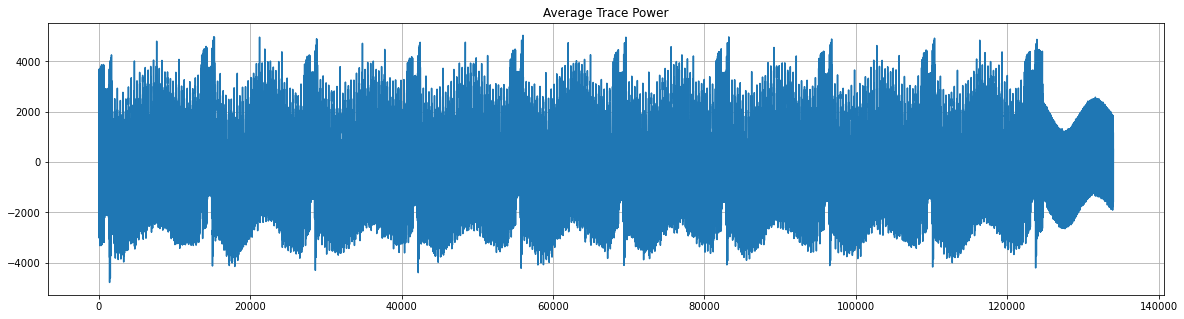

In [56]:
plt.figure(figsize=(20,5))
plt.title('Average Trace Power')
plt.plot(tempMeans[1].get())
plt.grid()
plt.show()

### 2. Calculate Sum of Differences
* After finding all of the means, calculate all of their absolute pairwise differences. Add these up. This will give one "trace" which has peaks where the samples are usually different. The calculation looks like

>$D_{i} = \sum_{k_1, k_2} |M_{k_1, i} - M_{k_2, i}|$


In [57]:
sumDiff = cp.zeros(len(trainTraces[0]))
for i in range(9):
    for j in range(i):
        sumDiff += cp.abs(tempMeans[i] - tempMeans[j])

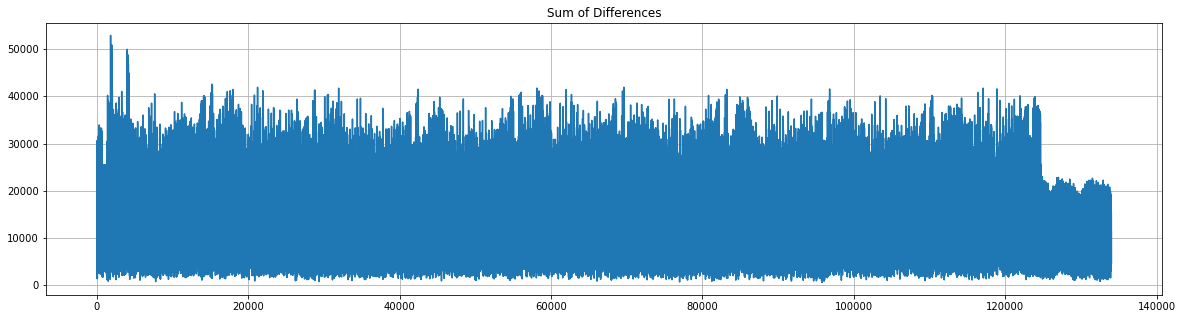

In [58]:
plt.figure(figsize=(20,5))
plt.title('Sum of Differences')
plt.plot(sumDiff.get())
plt.grid()
plt.show()

### Select POIs
* The peaks of $D_i$ show the most important points, but we need to satisfy point 1 from above - we need to pick some peaks that aren't too close. One algorithm to do this is:
1. Pick the highest point in $D_i$ and save this value of $i$ as a point of interest. (ie: $i = argmax(D_i)$)
2. Throw out the nearest $N$ points (where $N$ is the minimum spacing between POIs).
3. Repeat until enough POIs have been selected.

In [59]:
numPOIs = 5        # How many POIs do we want?
POIspacing = 5     # How far apart do the POIs have to be?

# Make an empty list of POIs
POIs = []
tempSumDiff = sumDiff.copy()
# Repeat until we have enough POIs
for i in range(numPOIs):
    # Find the biggest peak and add it to the list of POIs
    nextPOI = tempSumDiff.argmax().item()
    POIs.append(nextPOI)

    # Zero out some of the surrounding points
    # Make sure we don't go out of bounds
    poiMin = max(0, nextPOI - POIspacing)
    poiMax = min(nextPOI + POIspacing, len(tempSumDiff))
    for j in range(poiMin, poiMax):
        tempSumDiff[j] = 0

# Make sure they look okay
print(POIs)

[1822, 1972, 4020, 1935, 4132]


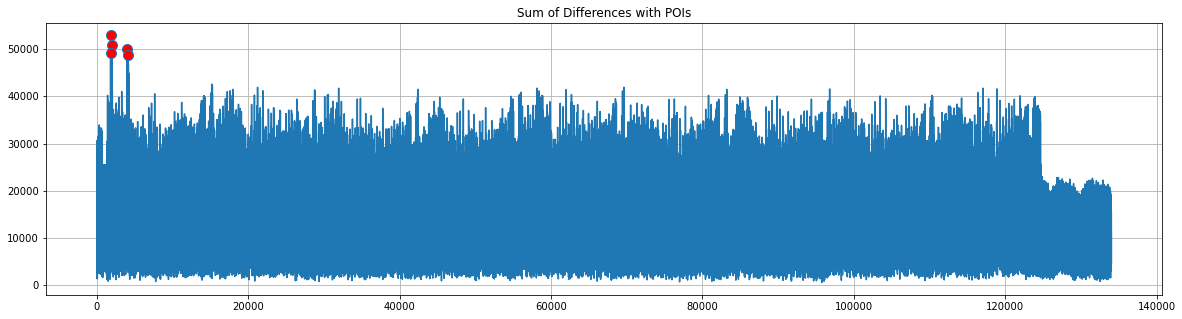

In [60]:
plt.figure(figsize=(20,5))
plt.plot(sumDiff.get(),
         marker='o',
         markerfacecolor='red',
         markersize=10,
         markevery=POIs
         )
plt.grid()
plt.title('Sum of Differences with POIs')
plt.show()

## Analyzing the Data

Suppose that we've picked $I$ points of interest, which are at samples $s_i (0 \le i < I)$. Then, our goal is to find a mean and covariance matrix for every operation (every choice of subkey or intermediate Hamming weight). Let's say that there are $K$ of these operations (maybe 256 subkeys or 9 possible Hamming weights).

For now, we'll look at a single operation $k (0 \le k < K)$. The steps are:


* Find every power trace $t$ that falls under the category of "operation $k$". (ex: find every power trace where we used a subkey of 0x01.) We'll say that there are $T_k$ of these, so $t_{j, s_i}$ means the value at trace $j$ and POI $i$.


### Find the average power $\mu_i$ at every point of interest
* Find the average power $\mu_i$ at every point of interest. This calculation will look like:

>$\mu_i = \frac{1}{T_k} \sum_{j=1}^{T_k} t_{j, s_i}$



In [61]:
meanMatrix = cp.zeros((9, numPOIs))
for HW in range(9):
    for i in range(numPOIs):
        meanMatrix[HW][i] = tempMeans[HW][POIs[i]]

### Find the covariance $c_{i, i^*}$ between the power at every pair of POIs ($i$ and $i^*$)
* Find the covariance $c_{i, i^*}$ between the power at every pair of POIs ($i$ and $i^*$). One way of calculating this is:

>$c_{i, i^*} = \frac{1}{T_k}  \sum_{j=1}^{T_k} (t_{j, s_i} - \mu_i) (t_{j, s_{i^*}} - \mu_{i^*})$



In [62]:
def cov(x, y):
    return cp.cov(x.T, y.T, bias=1)[0][1]

In [63]:
covMatrix  = cp.zeros((9, numPOIs, numPOIs))
for HW in range(9):
    if len(tempTracesHW[HW]) > 0:
        for i in range(numPOIs):
            for j in range(numPOIs):
                x = tempTracesHW[HW][:,POIs[i]]
                y = tempTracesHW[HW][:,POIs[j]]
                covMatrix[HW,i,j] = cov(x, y)

# Using the Template

With a template in hand, we can finish our attack. For the attack, we need a smaller number of traces - we'll say that we have $A$ traces. The sample values will be labeled $a_{j, s_i} (1 \le j \le A)$.

In [64]:
from scipy.stats import multivariate_normal

## Applying the Template

First, let's apply the template to a single trace. Our job is to decide how likely all of our key guesses are. We need to do the following:

* Put our trace values at the POIs into a vector. This vector will be

>$\mathbf{a_j} =
\begin{bmatrix}
a_{j,1} \\
a_{j,2} \\
a_{j,3} \\
\vdots
\end{bmatrix}$

* Calculate the PDF for every key guess and save these for later. This might look like:

>$p_{k, j} = f_k(\mathbf{a_j})$

* Repeat these two steps for all of the attack traces.
This process gives us an array of $p_{k, j}$, which says: "Looking at trace $j$, how likely is it that key $k$ is the correct one?"

## Combining the Results

The very last step is to combine our $p_{k, j}$ values to decide which key is the best fit. The easiest way to do this is to combine them as


>$P_k = \prod_{j=1}^{A} p_{k,j}$

For example, if we guessed that a subkey was equal to 0x00 and our PDF results in 3 traces were (0.9, 0.8, 0.95), then our overall result would be 0.684. Having one trace that doesn't match the template can cause this number to drop quickly, helping us eliminate the wrong guesses. Finally, we can pick the highest value of $P_k$, which tells us which guess fits the templates the best, and we're done!

This method of combining our per-trace results can suffer from precision issues. After multiplying many large or small numbers together, we could end up with numbers that are too large or small to fit into a floating point variable. An easy fix is to work with logarithms. Instead of using $P_k$ directly, we can calculate


$\log P_k = \sum_{j=1}^A \log p_{k,j}$

Comparing these logarithms will give us the same results without the precision issues.

In [ ]:
P_k = cp.zeros(256)

for j in range(len(atkTraces)):
    # Grab key points and put them in a matrix
    a = [atkTraces[j][POIs[i]] for i in range(len(POIs))]

    # Test each key
    for k in range(256):
        # Find HW coming out of sbox
        HW = hw[sbox[atkTexts[j][0] ^ k]]
        # Find p_{k,j}
        rv = multivariate_normal(meanMatrix[HW].get(), covMatrix[HW].get(), allow_singular=True)
        p_kj = rv.pdf(a)

        # Add it to running total
        P_k[k] += cp.log(p_kj)

    # Print our top 5 results so far
    # Best match on the right
    print(P_k.argsort()[-5:])

    if P_k.argsort()[-1] == key[0]:
        print("Key found in: " + str(j) + " traces")
        break

